This analysis was made by adapting [this](https://stmorse.github.io/journal/spotify-api.html) code.

In [2]:
import requests
from plotnine import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

CLIENT_ID = 'INSERT_YOUR_ID'
CLIENT_SECRET = 'INSERT_YOUR_SECRET'

/Users/luizfernandotoledo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [4]:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [5]:
# base URL of all Spotify API endpoints
BASE_URL = 'https://api.spotify.com/v1/'

# Track ID from the URI
track_id = '5HZL0dCma3yL8r9LILJV8S'

# actual GET request with proper header
r = requests.get(BASE_URL + 'tracks/' + track_id, headers=headers)

In [6]:
r = r.json()
r

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6mdiAmATAx73kdxrNrnlao'},
    'href': 'https://api.spotify.com/v1/artists/6mdiAmATAx73kdxrNrnlao',
    'id': '6mdiAmATAx73kdxrNrnlao',
    'name': 'Iron Maiden',
    'type': 'artist',
    'uri': 'spotify:artist:6mdiAmATAx73kdxrNrnlao'}],
  'available_markets': ['AD',
   'AE',
   'AG',
   'AL',
   'AM',
   'AO',
   'AR',
   'AT',
   'AU',
   'AZ',
   'BA',
   'BB',
   'BD',
   'BE',
   'BF',
   'BG',
   'BH',
   'BI',
   'BJ',
   'BN',
   'BO',
   'BR',
   'BS',
   'BT',
   'BW',
   'BY',
   'BZ',
   'CA',
   'CD',
   'CG',
   'CH',
   'CI',
   'CL',
   'CM',
   'CO',
   'CR',
   'CV',
   'CW',
   'CY',
   'CZ',
   'DE',
   'DJ',
   'DK',
   'DM',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FJ',
   'FM',
   'FR',
   'GA',
   'GB',
   'GD',
   'GE',
   'GH',
   'GM',
   'GN',
   'GQ',
   'GR',
   'GT',
   'GW',
   'GY',
   'HK',
   'HN',
   'HR',
   'HT',


In [7]:
# WE NEED TO MAKE TWO REQUESTS FOR THE API AS ITS LIMIT IS 50 AND THERE ARE 61 ALBUMS THERE.
# WE USE "OFFSET" FEATURE TO DO A FIRST REQUEST FROM ALBUM 0 TO 50 AND GET THE FIRST 50 ALBUMS, 
# THEM OFFSET 50 TO START FROM WHERE THE FIRST REQUEST ENDED.

artist_id = '6mdiAmATAx73kdxrNrnlao'

# pull all artists albums
r = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50, 'offset':0})
d = r.json()
r2 = requests.get(BASE_URL + 'artists/' + artist_id + '/albums', 
                 headers=headers, 
                 params={'include_groups': 'album', 'limit': 50, 'offset':50})
d2 = r2.json()
# d.update(d2)

In [8]:
# Let's group the first 50 albuns with the rest and get 61.

items = d['items'] + d2['items']
len(items)


61

In [9]:
# Check if we have every album
for album in items:
    print(album['name'], ' --- ', album['release_date'])

Senjutsu  ---  2021-09-03
Senjutsu  ---  2021-09-03
Nights of the Dead, Legacy of the Beast: Live in Mexico City  ---  2020-11-20
Nights of the Dead, Legacy of the Beast: Live in Mexico City  ---  2020-11-20
The Book of Souls: Live Chapter  ---  2017-11-17
The Book of Souls: The Live Chapter  ---  2017-11-17
The Book of Souls  ---  2015-09-04
The Book of Souls  ---  2015-09-04
Maiden England '88 (2013 Remaster)  ---  2013-03-25
En Vivo!  ---  2012-03-26
En Vivo! (Live at Estadio Nacional, Santiago)  ---  2012-03-23
En Vivo! (Live at Estadio Nacional, Santiago)  ---  2012-03-23
The Final Frontier (2015 - Remaster)  ---  2010-08-16
The Final Frontier (Deluxe Edition)  ---  2010-08-13
The Final Frontier  ---  2010-08-13
The Final Frontier (2015 Remaster)  ---  2010
Flight 666: The Original Soundtrack (Live)  ---  2009-06-09
Flight 666: The Original Soundtrack  ---  2009-05-25
A Matter of Life and Death (2015 Remaster)  ---  2006-08-28
A Matter of Life and Death (2015 - Remaster)  ---  200

In [10]:
# Creating a list of dictionaires that contains every song, audio features 
# OBS: popularity and song features are in different parts of the API, so we need to make two different requests.
# audio features like danceability were extracted from BASE_URL + audio_features/ + track id
# track popularity was extracted from BASE_URL + tracks/ + track_id)

data = []   # will hold all track info
albums = [] # to keep track of duplicates
track_info = []
# loop over albums and get all tracks
for album in items:
    album_name = album['name']
    # this takes a few seconds so let's keep track of progress    
    print(album_name)
    # pull all tracks from this album
    r = requests.get(BASE_URL + 'albums/' + album['id'] + '/tracks', 
        headers=headers)
    tracks = r.json()['items']

    for track in tracks:
#         print(track['name'])
        # get audio features (key, liveness, danceability, ...)
        f = requests.get(BASE_URL + 'audio-features/' + track['id'], 
            headers=headers)
        f2 = requests.get(BASE_URL + 'tracks/' + track['id'], 
            headers=headers)
        f = f.json()
        f2 = f2.json()
        print('song name:' + track['name'] + ' and popularity: '+ str(f2['popularity']))
#         print(f'a')
        my_object = {
            "name": track['name'],
            "album_name": f2['album']['name'],
            "popularity": f2["popularity"],
            'release_date': f2['album']['release_date'],
            "valence": f["valence"],
            "danceability": f['danceability'],
            "energy": f['energy'],
            "danceability": f['danceability'],
            "key": f['key'],
            "loudness": f['loudness'],
            "mode": f['mode'],
            "speechiness": f['speechiness'],
            "danceability": f['danceability'],
            "acousticness": f['acousticness'],
            "instrumentalness": f['instrumentalness'],
            "liveness": f['liveness'],
            "tempo": f['tempo'],
            "duration_ms": f['duration_ms'],
            "danceability": f['danceability']
                    }
  
        track_info.append(my_object)
#         data.append(f)
track_info

      # combine with album info
#         f.update({
#             'track_name': track['name'],
#             'album_name': album_name,
# #             'short_album_name': trim_name,
# #             'release_date': album['release_date'],
#             'album_id': album['id']
#         })

Senjutsu
song name:Senjutsu and popularity: 43
song name:Stratego and popularity: 44
song name:The Writing On The Wall and popularity: 49
song name:Lost In A Lost World and popularity: 42
song name:Days Of Future Past and popularity: 46
song name:The Time Machine and popularity: 40
song name:Darkest Hour and popularity: 40
song name:Death Of The Celts and popularity: 38
song name:The Parchment and popularity: 40
song name:Hell On Earth and popularity: 40
Senjutsu
song name:Senjutsu and popularity: 57
song name:Stratego and popularity: 57
song name:The Writing On The Wall and popularity: 63
song name:Lost In A Lost World and popularity: 56
song name:Days Of Future Past and popularity: 59
song name:The Time Machine and popularity: 54
song name:Darkest Hour and popularity: 54
song name:Death Of The Celts and popularity: 52
song name:The Parchment and popularity: 54
song name:Hell On Earth and popularity: 54
Nights of the Dead, Legacy of the Beast: Live in Mexico City
song name:Churchill’s

song name:Wasted Years - Live at HSBC Arena, Rio De Janeiro, Brazil - 17th March 2016 and popularity: 16
The Book of Souls
song name:If Eternity Should Fail and popularity: 46
song name:Speed of Light and popularity: 52
song name:The Great Unknown and popularity: 40
song name:The Red and the Black and popularity: 49
song name:When the River Runs Deep and popularity: 38
song name:The Book of Souls and popularity: 43
song name:Death or Glory and popularity: 41
song name:Shadows of the Valley and popularity: 38
song name:Tears of a Clown and popularity: 42
song name:The Man of Sorrows and popularity: 38
song name:Empire of the Clouds and popularity: 46
The Book of Souls
song name:If Eternity Should Fail and popularity: 33
song name:Speed of Light and popularity: 39
song name:The Great Unknown and popularity: 28
song name:The Red and the Black and popularity: 36
song name:When the River Runs Deep and popularity: 27
song name:The Book of Souls and popularity: 31
song name:Death or Glory and

song name:The Man Who Would Be King and popularity: 0
song name:When The Wild Wind Blows and popularity: 0
The Final Frontier
song name:Satellite 15 and popularity: 8
song name:El Dorado and popularity: 8
song name:Mother Of Mercy and popularity: 6
song name:Coming Home and popularity: 14
song name:The Alchemist and popularity: 6
song name:Isle Of Avalon and popularity: 5
song name:Starblind and popularity: 5
song name:The Talisman and popularity: 7
song name:The Man Who Would Be King and popularity: 6
song name:When The Wild Wind Blows and popularity: 10
The Final Frontier (2015 Remaster)
song name:Satellite 15.....The Final Frontier - 2015 Remaster and popularity: 39
song name:El Dorado - 2015 Remaster and popularity: 40
song name:Mother of Mercy - 2015 Remaster and popularity: 37
song name:Coming Home - 2015 Remaster and popularity: 44
song name:The Alchemist - 2015 Remaster and popularity: 37
song name:Isle of Avalon - 2015 Remaster and popularity: 35
song name:Starblind - 2015 Rem

song name:Journeyman - 2015 Remaster and popularity: 27
Dance of Death (2015 Remaster)
song name:Wildest Dreams - 2015 Remaster and popularity: 39
song name:Rainmaker - 2015 Remaster and popularity: 46
song name:No More Lies - 2015 Remaster and popularity: 44
song name:Montségur - 2015 Remaster and popularity: 39
song name:Dance of Death - 2015 Remaster and popularity: 56
song name:Gates of Tomorrow - 2015 Remaster and popularity: 37
song name:New Frontier - 2015 Remaster and popularity: 37
song name:Paschendale - 2015 Remaster and popularity: 44
song name:Face in the Sand - 2015 Remaster and popularity: 38
song name:Age of Innocence - 2015 Remaster and popularity: 36
song name:Journeyman - 2015 Remaster and popularity: 46
BBC Archives (Live)
song name:Iron Maiden - Live: Radio 1 Rock Show, 14 November 1979 and popularity: 20
song name:Running Free - Live: Radio 1 Rock Show, 14 November 1979 and popularity: 20
song name:Transylvania - Live: Radio 1 Rock Show, 14 November 1979 and popul

song name:Brave New World - Live '01 and popularity: 40
song name:Wrathchild - Live '01 and popularity: 38
song name:2 Minutes To Midnight - Live '01 and popularity: 39
song name:Blood Brothers - Live '01 and popularity: 39
song name:Sign of the Cross - Live At Rock in Rio '01 and popularity: 40
song name:The Mercenary - Live '01 and popularity: 35
song name:The Trooper - Live '01 and popularity: 40
song name:Dream Of Mirrors - Live '01 and popularity: 37
song name:The Clansman - Live At Rock in Rio '01 and popularity: 42
song name:The Evil That Men Do - Live '01 and popularity: 38
song name:Fear of the Dark - Live '01 and popularity: 51
song name:Iron Maiden - Live '01 and popularity: 35
song name:The Number Of The Beast - Live '01 and popularity: 37
song name:Hallowed Be Thy Name - Live '01 and popularity: 40
song name:Sanctuary - Live '01 and popularity: 32
song name:Run To The Hills - Live '01 and popularity: 39
Brave New World (2015 - Remaster)
song name:The Wicker Man - 2015 Rema

song name:Wrathchild - Live at Donington; 1998 Remaster and popularity: 23
song name:From Here to Eternity - Live at Donington; 1998 Remaster and popularity: 23
song name:Can I Play With Madness - Live at Donington; 1998 Remaster and popularity: 22
song name:Wasting Love - Live at Donington; 1998 Remaster and popularity: 25
song name:Tailgunner - Live at Donington; 1998 Remaster and popularity: 22
song name:The Evil That Men Do - Live at Donington; 1998 Remaster and popularity: 23
song name:Afraid To Shoot Strangers - Live at Donington; 1998 Remaster and popularity: 25
song name:Fear Of The Dark - Live at Donington; 1998 Remaster and popularity: 27
song name:Bring Your Daughter...To The Slaughter - Live at Donington; 1998 Remaster and popularity: 25
song name:The Clairvoyant - Live at Donington; 1998 Remaster and popularity: 23
song name:Heaven Can Wait - Live at Donington; 1998 Remaster and popularity: 21
song name:Run To The Hills - Live at Donington; 1998 Remaster and popularity: 22

song name:Sanctuary - Live at Birmingham NEC, 1988; 2013 Remaster and popularity: 18
Seventh Son of a Seventh Son (2015 Remaster)
song name:Moonchild - 2015 Remaster and popularity: 50
song name:Infinite Dreams - 2015 Remaster and popularity: 48
song name:Can I Play with Madness - 2015 Remaster and popularity: 59
song name:The Evil That Men Do - 2015 Remaster and popularity: 57
song name:Seventh Son of a Seventh Son - 2015 Remaster and popularity: 53
song name:The Prophecy - 2015 Remaster and popularity: 44
song name:The Clairvoyant - 2015 Remaster and popularity: 48
song name:Only the Good Die Young - 2015 Remaster and popularity: 46
Somewhere in Time (2015 - Remaster)
song name:Caught Somewhere in Time - 2015 Remaster and popularity: 42
song name:Wasted Years - 2015 Remaster and popularity: 55
song name:Sea of Madness - 2015 Remaster and popularity: 35
song name:Heaven Can Wait - 2015 Remaster and popularity: 36
song name:The Loneliness of the Long Distance Runner - 2015 Remaster and

song name:Run to the Hills - 2015 Remaster and popularity: 72
song name:Gangland - 2015 Remaster and popularity: 45
song name:Hallowed Be Thy Name - 2015 Remaster and popularity: 67
Killers (2015 - Remaster)
song name:The Ides of March - 2015 Remaster and popularity: 34
song name:Wrathchild - 2015 Remaster and popularity: 44
song name:Murders in the Rue Morgue - 2015 Remaster and popularity: 37
song name:Another Life - 2015 Remaster and popularity: 33
song name:Genghis Khan - 2015 Remaster and popularity: 34
song name:Innocent Exile - 2015 Remaster and popularity: 32
song name:Killers - 2015 Remaster and popularity: 42
song name:Prodigal Son - 2015 Remaster and popularity: 32
song name:Purgatory - 2015 Remaster and popularity: 35
song name:Drifter - 2015 Remaster and popularity: 31
Killers (2015 Remaster)
song name:The Ides of March - 2015 Remaster and popularity: 42
song name:Wrathchild - 2015 Remaster and popularity: 52
song name:Murders in the Rue Morgue - 2015 Remaster and populari

[{'name': 'Senjutsu',
  'album_name': 'Senjutsu',
  'popularity': 43,
  'release_date': '2021-09-03',
  'valence': 0.466,
  'danceability': 0.347,
  'energy': 0.885,
  'key': 9,
  'loudness': -6.121,
  'mode': 0,
  'speechiness': 0.0615,
  'acousticness': 0.000171,
  'instrumentalness': 0.0892,
  'liveness': 0.217,
  'tempo': 180.172,
  'duration_ms': 500171},
 {'name': 'Stratego',
  'album_name': 'Senjutsu',
  'popularity': 44,
  'release_date': '2021-09-03',
  'valence': 0.465,
  'danceability': 0.473,
  'energy': 0.968,
  'key': 4,
  'loudness': -7.297,
  'mode': 0,
  'speechiness': 0.0642,
  'acousticness': 0.000144,
  'instrumentalness': 0.0347,
  'liveness': 0.612,
  'tempo': 138.054,
  'duration_ms': 299946},
 {'name': 'The Writing On The Wall',
  'album_name': 'Senjutsu',
  'popularity': 49,
  'release_date': '2021-09-03',
  'valence': 0.566,
  'danceability': 0.402,
  'energy': 0.912,
  'key': 2,
  'loudness': -5.447,
  'mode': 0,
  'speechiness': 0.0442,
  'acousticness': 0.0

In [16]:
track_info

[{'name': 'Senjutsu',
  'album_name': 'Senjutsu',
  'popularity': 43,
  'release_date': '2021-09-03',
  'valence': 0.466,
  'danceability': 0.347,
  'energy': 0.885,
  'key': 9,
  'loudness': -6.121,
  'mode': 0,
  'speechiness': 0.0615,
  'acousticness': 0.000171,
  'instrumentalness': 0.0892,
  'liveness': 0.217,
  'tempo': 180.172,
  'duration_ms': 500171},
 {'name': 'Stratego',
  'album_name': 'Senjutsu',
  'popularity': 44,
  'release_date': '2021-09-03',
  'valence': 0.465,
  'danceability': 0.473,
  'energy': 0.968,
  'key': 4,
  'loudness': -7.297,
  'mode': 0,
  'speechiness': 0.0642,
  'acousticness': 0.000144,
  'instrumentalness': 0.0347,
  'liveness': 0.612,
  'tempo': 138.054,
  'duration_ms': 299946},
 {'name': 'The Writing On The Wall',
  'album_name': 'Senjutsu',
  'popularity': 49,
  'release_date': '2021-09-03',
  'valence': 0.566,
  'danceability': 0.402,
  'energy': 0.912,
  'key': 2,
  'loudness': -5.447,
  'mode': 0,
  'speechiness': 0.0442,
  'acousticness': 0.0

In [17]:
# turn everything into a single table
import pandas as pd

df = pd.DataFrame(track_info)
len(df)

791

In [18]:
# how the dataframe looks like
df.head(5)

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
0,Senjutsu,Senjutsu,43,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.089200,0.2170,180.172,500171
1,Stratego,Senjutsu,44,2021-09-03,0.465,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946
2,The Writing On The Wall,Senjutsu,49,2021-09-03,0.566,0.402,0.912,2,-5.447,0,0.0442,0.001580,0.000179,0.0923,90.045,373899
3,Lost In A Lost World,Senjutsu,42,2021-09-03,0.206,0.251,0.871,4,-6.414,0,0.0871,0.004070,0.007510,0.1080,92.975,571584
4,Days Of Future Past,Senjutsu,46,2021-09-03,0.476,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755


In [22]:
# fix the release_date column
df.release_date = pd.to_datetime(df.release_date)
df['year'] = pd.DatetimeIndex(df['release_date']).year
df.head(1)

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
0,Senjutsu,Senjutsu,43,2021-09-03,0.466,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.0892,0.217,180.172,500171,2021


In [23]:
# save to csv
df.to_csv('discography.csv', index=False)


In [120]:
#remove live albums and keep only the 17 studio albums, with 152 songs

only_studio = df[df.album_name.isin(['The Book of Souls', 'The Final Frontier', 'A Matter of Life and Death (2015 Remaster)', 'Dance of Death (2015 Remaster)', 'Brave New World (2015 Remaster)', 'Virtual XI (2015 Remaster)', 'The X Factor (2015 Remaster)', 'Fear of the Dark (2015 Remaster)',
       'No Prayer for the Dying (2015 Remaster)',
       'Seventh Son of a Seventh Son (2015 Remaster)',
       'Somewhere in Time (2015 Remaster)', 'Powerslave (2015 Remaster)',
       'Piece of Mind (2015 Remaster)',
       'The Number of the Beast (2015 Remaster)',
       'Killers (2015 Remaster)', 'Iron Maiden (2015 Remaster)', 'Senjutsu'])]


In [123]:
#remove duplicate
print(len(only_studio.name))
only_studio.drop_duplicates('name', inplace=True)
print(len(only_studio.name))
only_studio

162
162


/Users/luizfernandotoledo/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
0,Senjutsu,Senjutsu,43,2021-09-03,0.4660,0.347,0.885,9,-6.121,0,0.0615,0.000171,0.089200,0.2170,180.172,500171,2021
1,Stratego,Senjutsu,44,2021-09-03,0.4650,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021
2,The Writing On The Wall,Senjutsu,49,2021-09-03,0.5660,0.402,0.912,2,-5.447,0,0.0442,0.001580,0.000179,0.0923,90.045,373899,2021
3,Lost In A Lost World,Senjutsu,42,2021-09-03,0.2060,0.251,0.871,4,-6.414,0,0.0871,0.004070,0.007510,0.1080,92.975,571584,2021
4,Days Of Future Past,Senjutsu,46,2021-09-03,0.4760,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755,2021
5,The Time Machine,Senjutsu,40,2021-09-03,0.3160,0.297,0.889,9,-5.287,0,0.0607,0.006540,0.000211,0.1180,116.650,429444,2021
6,Darkest Hour,Senjutsu,40,2021-09-03,0.1620,0.222,0.925,4,-5.939,0,0.2400,0.054200,0.086300,0.3950,133.772,440465,2021
7,Death Of The Celts,Senjutsu,38,2021-09-03,0.2600,0.291,0.804,2,-5.807,1,0.0414,0.007110,0.210000,0.1200,134.561,620403,2021
8,The Parchment,Senjutsu,40,2021-09-03,0.2120,0.149,0.924,4,-5.345,0,0.0933,0.014100,0.219000,0.1070,80.234,758991,2021
9,Hell On Earth,Senjutsu,40,2021-09-03,0.0628,0.298,0.842,4,-6.692,0,0.0563,0.009520,0.029900,0.0846,132.650,679135,2021


In [124]:
#remove "remastered" from the album names
only_studio['album_name'] = only_studio['album_name'].apply(lambda x: x.split(' (')[0])

/var/folders/dj/5c61qy0d0b9gcj0yrt1jd2300000gn/T/ipykernel_93109/3091567604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
only_studio.album_name.unique()

array(['Senjutsu', 'The Book of Souls', 'The Final Frontier',
       'A Matter of Life and Death', 'Dance of Death', 'Brave New World',
       'Virtual XI', 'The X Factor', 'Fear of the Dark',
       'No Prayer for the Dying', 'Seventh Son of a Seventh Son',
       'Somewhere in Time', 'Powerslave', 'Piece of Mind',
       'The Number of the Beast', 'Killers', 'Iron Maiden'], dtype=object)

In [126]:
#remove "remastered" from the song names
only_studio['name'] = only_studio['name'].apply(lambda x: x.split(' -')[0])

/var/folders/dj/5c61qy0d0b9gcj0yrt1jd2300000gn/T/ipykernel_93109/766336293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [127]:
only_studio.name.unique()

array(['Senjutsu', 'Stratego', 'The Writing On The Wall',
       'Lost In A Lost World', 'Days Of Future Past', 'The Time Machine',
       'Darkest Hour', 'Death Of The Celts', 'The Parchment',
       'Hell On Earth', 'If Eternity Should Fail', 'Speed of Light',
       'The Great Unknown', 'The Red and the Black',
       'When the River Runs Deep', 'The Book of Souls', 'Death or Glory',
       'Shadows of the Valley', 'Tears of a Clown', 'The Man of Sorrows',
       'Empire of the Clouds', 'Satellite 15', 'El Dorado',
       'Mother Of Mercy', 'Coming Home', 'The Alchemist',
       'Isle Of Avalon', 'Starblind', 'The Talisman',
       'The Man Who Would Be King', 'When The Wild Wind Blows',
       'Different World', "These Colours Don't Run",
       'Brighter Than a Thousand Suns', 'The Pilgrim', 'The Longest Day',
       'Out of the Shadows', 'The Reincarnation of Benjamin Breeg',
       'For the Greater Good of God', 'Lord of Light', 'The Legacy',
       'Wildest Dreams', 'Rainmaker'

In [128]:
only_studio.album_name.unique()

array(['Senjutsu', 'The Book of Souls', 'The Final Frontier',
       'A Matter of Life and Death', 'Dance of Death', 'Brave New World',
       'Virtual XI', 'The X Factor', 'Fear of the Dark',
       'No Prayer for the Dying', 'Seventh Son of a Seventh Son',
       'Somewhere in Time', 'Powerslave', 'Piece of Mind',
       'The Number of the Beast', 'Killers', 'Iron Maiden'], dtype=object)

In [129]:
only_studio.valence.mean()

0.38662654320987655

In [130]:
only_studio.sort_values(by='valence', ascending=False).head(10)

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
766,Wrathchild,Killers,52,1981-01-01,0.782,0.438,0.930,9,-4.959,1,0.0484,0.018800,0.349000,0.1960,104.812,175053,1981
785,Running Free,Iron Maiden,52,1980-01-01,0.764,0.478,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980
597,Weekend Warrior,Fear of the Dark,41,1992-01-01,0.759,0.359,0.938,7,-4.606,1,0.0682,0.007070,0.000000,0.2960,135.054,339493,1992
713,Aces High,Powerslave,64,1984-01-01,0.756,0.300,0.936,2,-5.399,1,0.0456,0.033700,0.021000,0.1580,133.065,271907,1984
465,Futureal,Virtual XI,41,1998-01-01,0.706,0.398,0.990,4,-3.208,0,0.0841,0.006100,0.002920,0.3140,99.785,175120,1998
595,The Apparition,Fear of the Dark,40,1992-01-01,0.693,0.592,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992
747,Invaders,The Number of the Beast,49,1982-01-01,0.684,0.439,0.937,4,-5.410,0,0.0493,0.017500,0.025200,0.4960,111.794,203387,1982
734,The Trooper,Piece of Mind,75,1983-01-01,0.669,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,252733,1983
768,Another Life,Killers,41,1981-01-01,0.666,0.201,0.959,2,-5.130,1,0.1400,0.001130,0.422000,0.1770,184.314,203507,1981
646,Infinite Dreams,Seventh Son of a Seventh Son,48,1988-01-01,0.659,0.196,0.962,4,-4.533,0,0.0955,0.026900,0.000044,0.1480,78.783,369373,1988


In [131]:
pd.set_option('display.max_rows', None)
# select only name and valence columns

name_valence = only_studio[["name", "valence"]]
name_valence

name_valence.to_csv('name_valence.csv', index=False)
name_valence

,name,valence
0,Senjutsu,0.4660
1,Stratego,0.4650
2,The Writing On The Wall,0.5660
3,Lost In A Lost World,0.2060
4,Days Of Future Past,0.4760
5,The Time Machine,0.3160
6,Darkest Hour,0.1620
7,Death Of The Celts,0.2600
8,The Parchment,0.2120
9,Hell On Earth,0.0628


In [177]:
pd.set_option('display.max_rows', None)
# select only name and valence columns

name_valence_popularity = only_studio[["name", "valence", 'popularity']]
name_valence_popularity = name_valence_popularity.sort_values('popularity', ascending=False).head(20)

name_valence_popularity.to_csv('name_valence_popularity.csv', index=False)
name_valence_popularity

,name,valence,popularity
734,The Trooper,0.669,75
752,Run to the Hills,0.458,72
598,Fear of the Dark,0.227,72
751,The Number of the Beast,0.268,69
754,Hallowed Be Thy Name,0.300,67
714,2 Minutes to Midnight,0.595,66
592,Wasting Love,0.290,66
662,Wasted Years,0.492,66
713,Aces High,0.756,64
447,The Wicker Man,0.296,60


In [178]:
# is there a correlation between popularity and valence?
import statsmodels.formula.api as smf

model = smf.ols("popularity ~ valence", data=name_valence_popularity)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.4185
Date:                Sun, 20 Feb 2022   Prob (F-statistic):              0.526
Time:                        19:07:34   Log-Likelihood:                -64.710
No. Observations:                  20   AIC:                             133.4
Df Residuals:                      18   BIC:                             135.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.8162      4.104     14.576      0.000      51.194      68.438
valence        5.9944      9.266      0.647      0.526     -13.472      25.461
==============================================================================
Omnibus:                        3.665   Durbin-Watson:                   0.095
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.021
Skew:                           0.525   Prob(JB):                        0.364
Kurtosis:                       1.851   Cond. No.                         7.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
# There is a correlation, but happiness level explains only 2% of a song popularity.  How happy are their 10 most popular songs?

name_valence_popularity.sort_values('popularity', ascending=False).head(10)



,name,valence,popularity
734,The Trooper,0.669,75
752,Run to the Hills,0.458,72
598,Fear of the Dark,0.227,72
751,The Number of the Beast,0.268,69
754,Hallowed Be Thy Name,0.300,67
714,2 Minutes to Midnight,0.595,66
592,Wasting Love,0.290,66
662,Wasted Years,0.492,66
713,Aces High,0.756,64
447,The Wicker Man,0.296,60


In [162]:
only_studio.columns

Index(['name', 'album_name', 'popularity', 'release_date', 'valence',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms',
       'year'],
      dtype='object')

In [172]:
# is there a correlation between energy and popularity?
import statsmodels.formula.api as smf

model = smf.ols("popularity ~ year", data=only_studio)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     38.91
Date:                Sun, 20 Feb 2022   Prob (F-statistic):           3.80e-09
Time:                        18:31:34   Log-Likelihood:                -620.57
No. Observations:                 162   AIC:                             1245.
Df Residuals:                     160   BIC:                             1251.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    939.2661    143.634      6.539      0.000     655.603    1222.929
year          -0.4489      0.072     -6.238      0.000      -0.591      -0.307
==============================================================================
Omnibus:                       16.581   Durbin-Watson:                   0.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.743
Skew:                          -0.629   Prob(JB):                     1.90e-05
Kurtosis:                       4.279   Cond. No.                     3.25e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

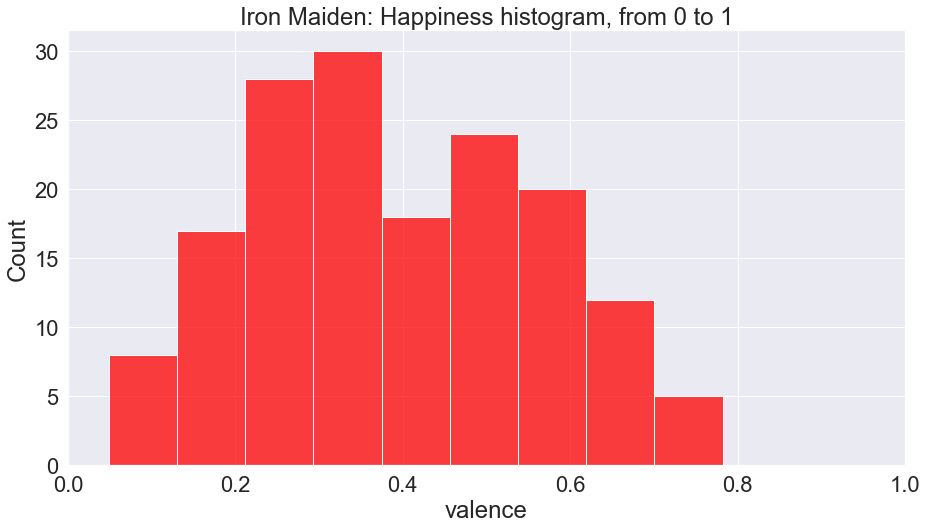

In [135]:
# valence histogram

sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 2)
sns.histplot(data=name_valence, x = 'valence', color='red').set(title='Iron Maiden: Happiness histogram, from 0 to 1')
plt.xlim(0, 1)
plt.savefig('valence_histogram.png')


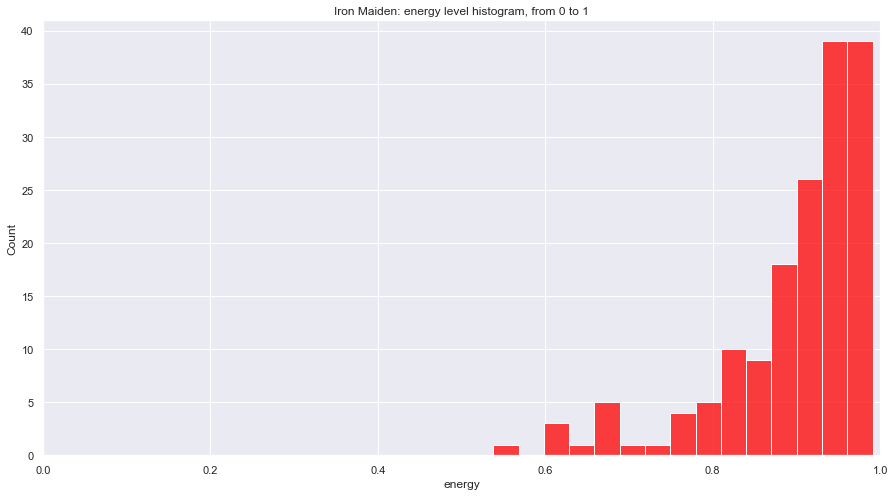

In [136]:
#energy histogram
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=only_studio, x = 'energy', color='red').set(title='Iron Maiden: energy level histogram, from 0 to 1')
plt.xlim(0, 1)
plt.savefig('energy_histogram.png')

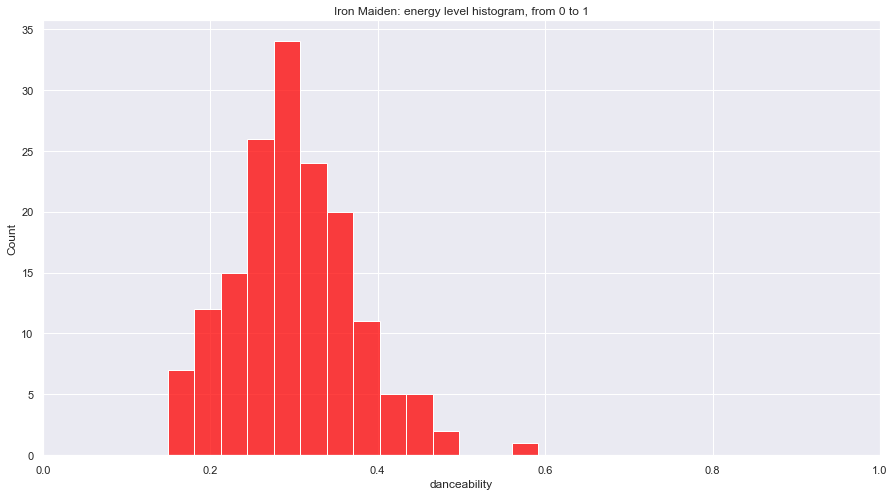

In [137]:
#danceability histogram
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=only_studio, x = 'danceability', color='red').set(title='Iron Maiden: energy level histogram, from 0 to 1')
plt.xlim(0, 1)
plt.savefig('danceability_histogram.png')

In [138]:
only_studio.sort_values('danceability', ascending=False)

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
595,The Apparition,Fear of the Dark,40,1992-01-01,0.6930,0.592,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992
785,Running Free,Iron Maiden,52,1980-01-01,0.7640,0.478,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980
1,Stratego,Senjutsu,44,2021-09-03,0.4650,0.473,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021
668,Alexander the Great (356-323 B.C.),Somewhere in Time,53,1986-01-01,0.2880,0.454,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093,1986
714,2 Minutes to Midnight,Powerslave,66,1984-01-01,0.5950,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,363587,1984
93,The Man of Sorrows,The Book of Souls,38,2015-09-04,0.2910,0.441,0.780,2,-5.488,0,0.0418,0.024200,0.000063,0.2300,110.180,387543,2015
747,Invaders,The Number of the Beast,49,1982-01-01,0.6840,0.439,0.937,4,-5.410,0,0.0493,0.017500,0.025200,0.4960,111.794,203387,1982
766,Wrathchild,Killers,52,1981-01-01,0.7820,0.438,0.930,9,-4.959,1,0.0484,0.018800,0.349000,0.1960,104.812,175053,1981
4,Days Of Future Past,Senjutsu,46,2021-09-03,0.4760,0.433,0.920,4,-4.738,0,0.0409,0.000576,0.000055,0.1230,92.466,243755,2021
447,The Wicker Man,Brave New World,60,2000-01-01,0.2960,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,275253,2000


In [139]:
# valence vs years
years_valence = only_studio[["name", "album_name", "year", 'valence']]

years_valence.to_csv('years_valence.csv', index=False)

years_valence



,name,album_name,year,valence
0,Senjutsu,Senjutsu,2021,0.4660
1,Stratego,Senjutsu,2021,0.4650
2,The Writing On The Wall,Senjutsu,2021,0.5660
3,Lost In A Lost World,Senjutsu,2021,0.2060
4,Days Of Future Past,Senjutsu,2021,0.4760
5,The Time Machine,Senjutsu,2021,0.3160
6,Darkest Hour,Senjutsu,2021,0.1620
7,Death Of The Celts,Senjutsu,2021,0.2600
8,The Parchment,Senjutsu,2021,0.2120
9,Hell On Earth,Senjutsu,2021,0.0628


<AxesSubplot:xlabel='year'>

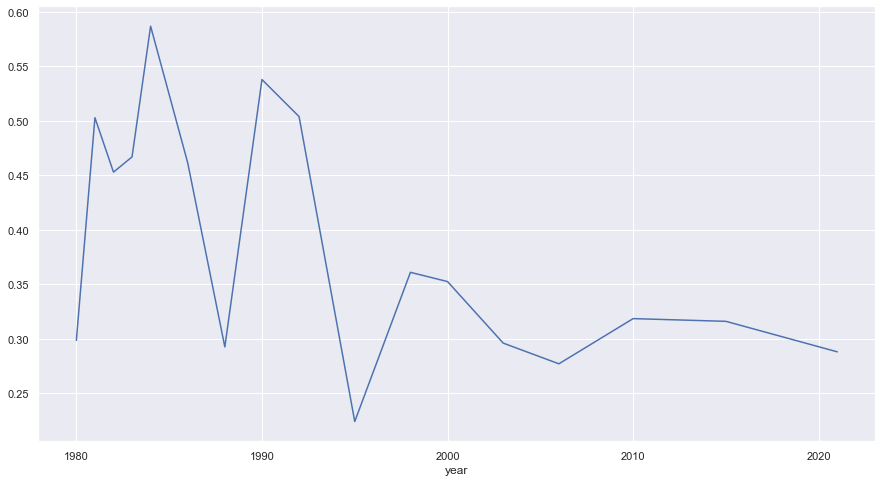

In [140]:
#median happiness for each year
years_valence.groupby('year').valence.median().plot()

In [141]:
# valence per album

album_mean_valence = years_valence.groupby('album_name').valence.mean()
album_mean_valence = pd.DataFrame(album_mean_valence.to_frame())
album_mean_valence = pd.DataFrame(album_mean_valence.to_records())
album_mean_valence

album_mean_valence.to_csv('album_mean_valence.csv', index=False)
album_mean_valence


,album_name,valence
0,A Matter of Life and Death,0.290450
1,Brave New World,0.368700
2,Dance of Death,0.330909
3,Fear of the Dark,0.481250
4,Iron Maiden,0.376000
5,Killers,0.513300
6,No Prayer for the Dying,0.484400
7,Piece of Mind,0.453556
8,Powerslave,0.530125
9,Senjutsu,0.319180


In [142]:
# Top 10 Iron Maiden happiest songs and when they were launched

top10happiest = years_valence.sort_values('valence', ascending=False).head(10)

top10happiest.to_csv('top10happiest.csv', index=False)

top10happiest

,name,album_name,year,valence
766,Wrathchild,Killers,1981,0.782
785,Running Free,Iron Maiden,1980,0.764
597,Weekend Warrior,Fear of the Dark,1992,0.759
713,Aces High,Powerslave,1984,0.756
465,Futureal,Virtual XI,1998,0.706
595,The Apparition,Fear of the Dark,1992,0.693
747,Invaders,The Number of the Beast,1982,0.684
734,The Trooper,Piece of Mind,1983,0.669
768,Another Life,Killers,1981,0.666
646,Infinite Dreams,Seventh Son of a Seventh Son,1988,0.659


In [143]:
# Top 10 Iron Maiden saddest songs and when they were launched

top10saddest = years_valence.sort_values('valence').head(10)

top10saddest.to_csv('top10saddest.csv', index=False)
top10saddest

,name,album_name,year,valence
257,Lord of Light,A Matter of Life and Death,2006,0.0485
9,Hell On Earth,Senjutsu,2021,0.0628
86,The Great Unknown,The Book of Souls,2015,0.0702
200,Isle Of Avalon,The Final Frontier,2010,0.0739
484,Sign of the Cross,The X Factor,1995,0.0903
488,Look for the Truth,The X Factor,1995,0.0930
649,Seventh Son of a Seventh Son,Seventh Son of a Seventh Son,1988,0.0948
492,The Edge of Darkness,The X Factor,1995,0.1230
613,Fates Warning,No Prayer for the Dying,1990,0.1390
720,Rime of the Ancient Mariner,Powerslave,1984,0.1430


In [179]:
# danceability
maiden_danceability = only_studio[["name", "danceability"]]

maiden_danceability = maiden_danceability.sort_values('danceability', ascending=False).head(20)

maiden_danceability.to_csv('danceability.csv', index=False)
maiden_danceability

,name,danceability
595,The Apparition,0.592
785,Running Free,0.478
1,Stratego,0.473
668,Alexander the Great (356-323 B.C.),0.454
714,2 Minutes to Midnight,0.446
93,The Man of Sorrows,0.441
747,Invaders,0.439
766,Wrathchild,0.438
4,Days Of Future Past,0.433
447,The Wicker Man,0.424


In [145]:
# danceability
maiden_danceability_years = only_studio[["name", "danceability", 'year']]

maiden_danceability_years.to_csv('danceability_years.csv', index=False)
maiden_danceability_years

,name,danceability,year
0,Senjutsu,0.347,2021
1,Stratego,0.473,2021
2,The Writing On The Wall,0.402,2021
3,Lost In A Lost World,0.251,2021
4,Days Of Future Past,0.433,2021
5,The Time Machine,0.297,2021
6,Darkest Hour,0.222,2021
7,Death Of The Celts,0.291,2021
8,The Parchment,0.149,2021
9,Hell On Earth,0.298,2021


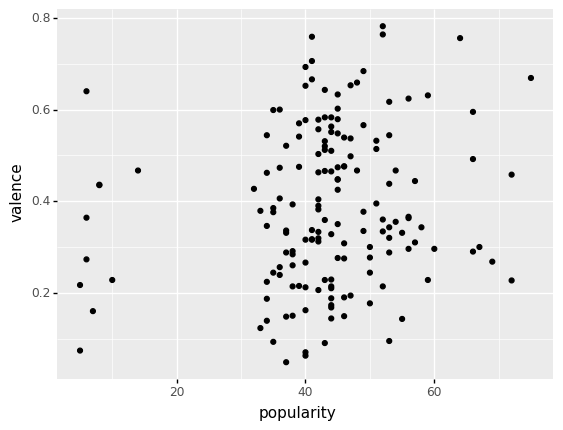

<ggplot: (373668274)>

In [146]:
(
    ggplot(only_studio,          # data
        aes('popularity', 'valence')) # aesthetics
        + geom_point()      # geometry
)

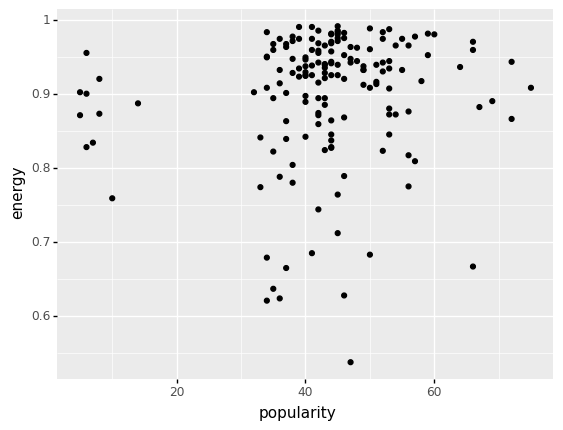

<ggplot: (373520887)>

In [147]:
(
    ggplot(only_studio,          # data
        aes('popularity', 'energy')) # aesthetics
        + geom_point()      # geometry
)

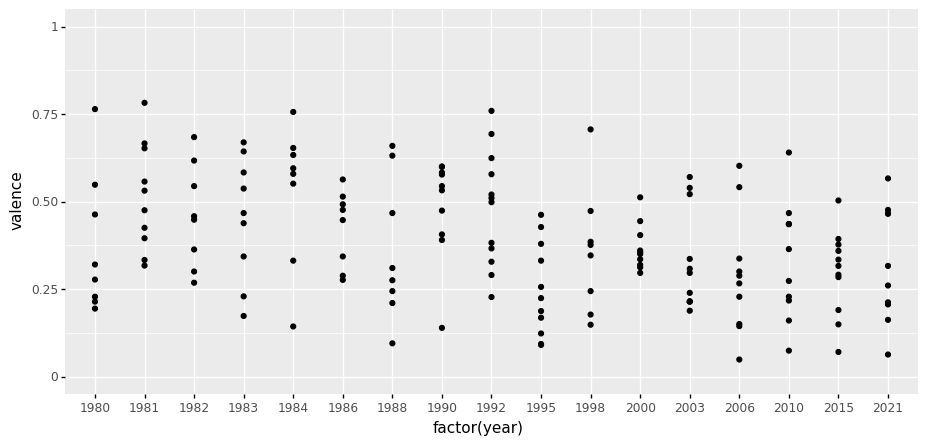

<ggplot: (373736807)>

In [148]:
#Valence per year

(
    ggplot(only_studio)
    + aes(x='factor(year)', y='valence')
    + geom_point()
    + coord_cartesian(ylim=(0, 1))
    + theme(figure_size=(11, 5)) # set chart dimensions
)

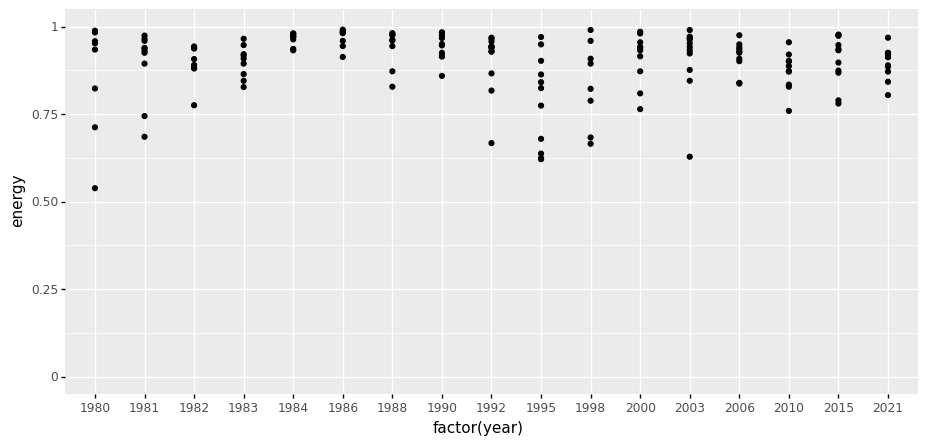

<ggplot: (373734675)>

In [149]:
#Energy per year

(
    ggplot(only_studio)
    + aes(x='factor(year)', y='energy')
    + geom_point()
    + coord_cartesian(ylim=(0, 1))
    + theme(figure_size=(11, 5)) # set chart dimensions
)

## Let's check Iron Maiden's average setlist for 2019 (I didn't find anything after 2019). It is displayed [here](https://www.setlist.fm/stats/average-setlist/iron-maiden-3bd6803c.html?year=2019)

These are the songs that we will analyze:
Aces High, Where Eagles Dare, 2 Minutes to Midnight, The Clansman, The Trooper, Revelations
For the Greater Good of God, The Wicker Man, Sign of the Cross, Flight of Icarus, Fear of the Dark
The Number of the Beast, Iron Maiden, The Evil That Men Do, Hallowed Be Thy Name, Run to the Hills

In [150]:
avg_concert = [
'Aces High', 
'Where Eagles Dare', 
'2 Minutes to Midnight', 
'The Clansman', 
'The Trooper', 
'Revelations'
'For the Greater Good of God', 
'The Wicker Man', 
'Sign of the Cross', 
'Flight of Icarus', 
'Fear of the Dark',
'The Number of the Beast',
'Iron Maiden', 
'The Evil That Men Do', 
'Hallowed Be Thy Name', 
'Run to the Hills'
]

avg_concert[-1]

'Run to the Hills'

In [151]:
avg_setlist_list = ['2 Minutes to Midnight','The Clansman', 
'The Trooper', 
'Revelations'
'For the Greater Good of God', 
'The Wicker Man', 
'Sign of the Cross', 
'Flight of Icarus', 
'Fear of the Dark',
'The Number of the Beast',
'Iron Maiden', 
'The Evil That Men Do', 
'Hallowed Be Thy Name', 
'Run to the Hills']

In [152]:
avg_setlist = {
    
1: '2 Minutes to Midnight',
2: 'The Clansman', 
3: 'The Trooper', 
4: 'Revelations',
5: 'For the Greater Good of God', 
6: 'The Wicker Man', 
7: 'Sign of the Cross', 
8: 'Flight of Icarus', 
9: 'Fear of the Dark',
10: 'The Number of the Beast',
11: 'Iron Maiden', 
12: 'The Evil That Men Do', 
13: 'Hallowed Be Thy Name', 
14: 'Run to the Hills '
    
}

avg_setlist

{1: '2 Minutes to Midnight',
 2: 'The Clansman',
 3: 'The Trooper',
 4: 'Revelations',
 5: 'For the Greater Good of God',
 6: 'The Wicker Man',
 7: 'Sign of the Cross',
 8: 'Flight of Icarus',
 9: 'Fear of the Dark',
 10: 'The Number of the Beast',
 11: 'Iron Maiden',
 12: 'The Evil That Men Do',
 13: 'Hallowed Be Thy Name',
 14: 'Run to the Hills '}

In [153]:
concert_dataframe = pd.DataFrame(avg_setlist.items(), columns=['Order', 'Song'])
concert_dataframe

,Order,Song
0,1,2 Minutes to Midnight
1,2,The Clansman
2,3,The Trooper
3,4,Revelations
4,5,For the Greater Good of God
5,6,The Wicker Man
6,7,Sign of the Cross
7,8,Flight of Icarus
8,9,Fear of the Dark
9,10,The Number of the Beast


In [154]:
concert_data = only_studio[only_studio.name.isin(avg_setlist_list)]
concert_data

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
447,The Wicker Man,Brave New World,60,2000-01-01,0.2960,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,275253,2000
468,The Clansman,Virtual XI,50,1998-01-01,0.1770,0.257,0.683,2,-6.670,1,0.0495,0.150000,0.011100,0.1160,154.106,539787,1998
484,Sign of the Cross,The X Factor,43,1995-01-01,0.0903,0.348,0.824,4,-7.718,0,0.0480,0.032900,0.654000,0.1120,100.816,676987,1995
598,Fear of the Dark,Fear of the Dark,72,1992-01-01,0.2270,0.308,0.866,2,-5.671,0,0.0590,0.000739,0.001410,0.2320,109.825,438120,1992
648,The Evil That Men Do,Seventh Son of a Seventh Son,57,1988-01-01,0.3100,0.255,0.977,4,-4.672,0,0.1100,0.008520,0.000003,0.0776,161.738,274213,1988
714,2 Minutes to Midnight,Powerslave,66,1984-01-01,0.5950,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,363587,1984
732,Flight of Icarus,Piece of Mind,58,1983-01-01,0.3430,0.368,0.917,6,-4.829,0,0.0772,0.147000,0.000121,0.1690,110.455,230760,1983
734,The Trooper,Piece of Mind,75,1983-01-01,0.6690,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,252733,1983
751,The Number of the Beast,The Number of the Beast,69,1982-01-01,0.2680,0.409,0.890,0,-6.839,1,0.0558,0.088000,0.107000,0.0935,100.409,290587,1982
752,Run to the Hills,The Number of the Beast,72,1982-01-01,0.4580,0.249,0.943,0,-5.188,1,0.0669,0.028600,0.004010,0.1620,173.671,233507,1982


In [155]:
merged = concert_data.merge(concert_dataframe, left_on='name', right_on='Song')
concert_order = merged.sort_values(by='Order')
concert_order


,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,Order,Song
5,2 Minutes to Midnight,Powerslave,66,1984-01-01,0.5950,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,363587,1984,1,2 Minutes to Midnight
1,The Clansman,Virtual XI,50,1998-01-01,0.1770,0.257,0.683,2,-6.670,1,0.0495,0.150000,0.011100,0.1160,154.106,539787,1998,2,The Clansman
7,The Trooper,Piece of Mind,75,1983-01-01,0.6690,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,252733,1983,3,The Trooper
0,The Wicker Man,Brave New World,60,2000-01-01,0.2960,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,275253,2000,6,The Wicker Man
2,Sign of the Cross,The X Factor,43,1995-01-01,0.0903,0.348,0.824,4,-7.718,0,0.0480,0.032900,0.654000,0.1120,100.816,676987,1995,7,Sign of the Cross
6,Flight of Icarus,Piece of Mind,58,1983-01-01,0.3430,0.368,0.917,6,-4.829,0,0.0772,0.147000,0.000121,0.1690,110.455,230760,1983,8,Flight of Icarus
3,Fear of the Dark,Fear of the Dark,72,1992-01-01,0.2270,0.308,0.866,2,-5.671,0,0.0590,0.000739,0.001410,0.2320,109.825,438120,1992,9,Fear of the Dark
8,The Number of the Beast,The Number of the Beast,69,1982-01-01,0.2680,0.409,0.890,0,-6.839,1,0.0558,0.088000,0.107000,0.0935,100.409,290587,1982,10,The Number of the Beast
10,Iron Maiden,Iron Maiden,50,1980-01-01,0.2770,0.322,0.988,0,-4.074,1,0.2320,0.000731,0.004110,0.4510,101.559,214360,1980,11,Iron Maiden
4,The Evil That Men Do,Seventh Son of a Seventh Son,57,1988-01-01,0.3100,0.255,0.977,4,-4.672,0,0.1100,0.008520,0.000003,0.0776,161.738,274213,1988,12,The Evil That Men Do


In [156]:
# transform microseconds into minutes
concert_order.duration_ms = concert_order.duration_ms / 60000
concert_order

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year,Order,Song
5,2 Minutes to Midnight,Powerslave,66,1984-01-01,0.5950,0.446,0.970,9,-5.004,0,0.0508,0.007540,0.000275,0.1990,94.233,6.059783,1984,1,2 Minutes to Midnight
1,The Clansman,Virtual XI,50,1998-01-01,0.1770,0.257,0.683,2,-6.670,1,0.0495,0.150000,0.011100,0.1160,154.106,8.996450,1998,2,The Clansman
7,The Trooper,Piece of Mind,75,1983-01-01,0.6690,0.285,0.908,4,-4.601,0,0.0705,0.031800,0.009090,0.3110,159.756,4.212217,1983,3,The Trooper
0,The Wicker Man,Brave New World,60,2000-01-01,0.2960,0.424,0.980,4,-4.330,0,0.1540,0.000855,0.000006,0.1290,101.502,4.587550,2000,6,The Wicker Man
2,Sign of the Cross,The X Factor,43,1995-01-01,0.0903,0.348,0.824,4,-7.718,0,0.0480,0.032900,0.654000,0.1120,100.816,11.283117,1995,7,Sign of the Cross
6,Flight of Icarus,Piece of Mind,58,1983-01-01,0.3430,0.368,0.917,6,-4.829,0,0.0772,0.147000,0.000121,0.1690,110.455,3.846000,1983,8,Flight of Icarus
3,Fear of the Dark,Fear of the Dark,72,1992-01-01,0.2270,0.308,0.866,2,-5.671,0,0.0590,0.000739,0.001410,0.2320,109.825,7.302000,1992,9,Fear of the Dark
8,The Number of the Beast,The Number of the Beast,69,1982-01-01,0.2680,0.409,0.890,0,-6.839,1,0.0558,0.088000,0.107000,0.0935,100.409,4.843117,1982,10,The Number of the Beast
10,Iron Maiden,Iron Maiden,50,1980-01-01,0.2770,0.322,0.988,0,-4.074,1,0.2320,0.000731,0.004110,0.4510,101.559,3.572667,1980,11,Iron Maiden
4,The Evil That Men Do,Seventh Son of a Seventh Son,57,1988-01-01,0.3100,0.255,0.977,4,-4.672,0,0.1100,0.008520,0.000003,0.0776,161.738,4.570217,1988,12,The Evil That Men Do


In [157]:
concert_sheet = concert_order[['name', 'valence']]
concert_sheet.to_csv('concert.csv', index=False)
concert_sheet




,name,valence
5,2 Minutes to Midnight,0.5950
1,The Clansman,0.1770
7,The Trooper,0.6690
0,The Wicker Man,0.2960
2,Sign of the Cross,0.0903
6,Flight of Icarus,0.3430
3,Fear of the Dark,0.2270
8,The Number of the Beast,0.2680
10,Iron Maiden,0.2770
4,The Evil That Men Do,0.3100


In [158]:
df.sort_values('danceability', ascending=False)

,name,album_name,popularity,release_date,valence,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,year
563,The Apparition - 2015 Remaster,Fear of the Dark (2015 - Remaster),26,1992-05-11,0.6930,0.5920,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992
595,The Apparition - 2015 Remaster,Fear of the Dark (2015 Remaster),40,1992-01-01,0.6930,0.5920,0.929,9,-4.281,1,0.0378,0.000985,0.000095,0.0777,98.092,234787,1992
785,Running Free - 2015 Remaster,Iron Maiden (2015 Remaster),52,1980-01-01,0.7640,0.4780,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980
777,Running Free - 2015 Remaster,Iron Maiden (2015 - Remaster),42,1980-04-14,0.7640,0.4780,0.823,11,-5.346,0,0.2060,0.000777,0.229000,0.1690,171.263,197573,1980
11,Stratego,Senjutsu,57,2021-09-03,0.4650,0.4730,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021
1,Stratego,Senjutsu,44,2021-09-03,0.4650,0.4730,0.968,4,-7.297,0,0.0642,0.000144,0.034700,0.6120,138.054,299946,2021
700,Wrathchild - Live at the Hammersmith Odeon; 19...,Live After Death (1998 Remaster),35,1985-01-01,0.3570,0.4660,0.968,0,-9.423,1,0.0499,0.002040,0.887000,0.9760,103.989,184133,1985
682,Wrathchild - Live at the Hammersmith Odeon; 19...,Live After Death (1998 Remaster),25,1985-10-14,0.3650,0.4540,0.975,4,-9.397,0,0.0497,0.001890,0.863000,0.9910,103.947,185707,1985
660,Alexander the Great (356-323 B.C.) - 2015 Rema...,Somewhere in Time (2015 - Remaster),41,1986-09-29,0.2880,0.4540,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093,1986
668,Alexander the Great (356-323 B.C.) - 2015 Rema...,Somewhere in Time (2015 Remaster),53,1986-01-01,0.2880,0.4540,0.944,4,-5.003,0,0.0849,0.084000,0.011900,0.1100,113.321,517093,1986
